In [10]:
#   IMPORTS
import csv
import cv2
import numpy as np
import supervision as sv
from tqdm import tqdm
from ultralytics import YOLO
from supervision.assets import VideoAssets, download_assets
from collections import defaultdict, deque


In [11]:
OUTPUT_CSV_PATH = "output-10sec.csv"
def write_to_csv(data):
    with open(OUTPUT_CSV_PATH, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(data)

def get_timestamp():
    import time
    import datetime
    timestamp = time.time()
    dt_object = datetime.datetime.fromtimestamp(timestamp)
    timestamp = "%Y-%m-%d %H:%M:%S" 
    timestamp = dt_object.strftime(timestamp)
    return timestamp

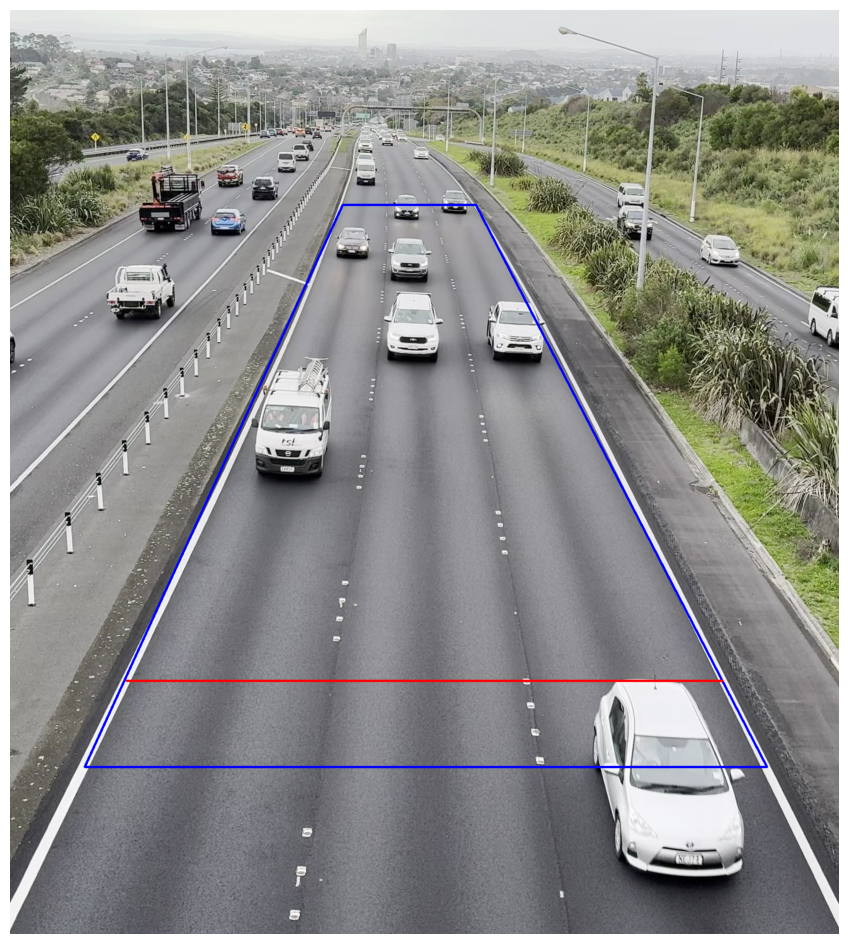

In [12]:
#   CONFIGURATIONs

SOURCE_VIDEO_PATH = "input-10sec.mov"
TARGET_VIDEO_PATH = "output-10sec.mp4"
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.5
MODEL_NAME = "yolov8n.pt"
# MODEL_RESOLUTION = 3840
MODEL_RESOLUTION = 1792

# SOURCE = np.array([
#     [654,192],
#     [1330,192],
#     [1950,784],
#     [100,782]
# ])
#  IMG_6429.MOV
# SOURCE = np.array([
#     [1785,500],
#     [2065,500],
#     [2724,1840],
#     [1120,1840]
# ])
#  IMG_6445.MOV
SOURCE = np.array([
    [714,418],
    [1000,418],
    [1625,1625],
    [160,1625]
])

# TARGET_WIDTH = 27.42
# TARGET_HEIGHT = 30
TARGET_WIDTH = 10.7
TARGET_HEIGHT = 100

TARGET = np.array([
    [0, 0],
    [TARGET_WIDTH - 1, 0],
    [TARGET_WIDTH - 1, TARGET_HEIGHT - 1],
    [0, TARGET_HEIGHT - 1],
])

# LINE ZONE
#  IMG_6429.MOV
# LINES = [
#     {"start": sv.Point(1285, 1530), "end": sv.Point(1734, 1530)},
#     {"start": sv.Point(1735, 1530), "end": sv.Point(2150, 1530)},
#     {"start": sv.Point(2151, 1530), "end": sv.Point(2575, 1530)},
# ]
#  IMG_6445.MOV
LINES = [
    {"start": sv.Point(250,1440), "end": sv.Point(665, 1440)},
    {"start": sv.Point(665, 1440), "end": sv.Point(1110, 1440)},
    {"start": sv.Point(1110, 1440), "end": sv.Point(1530,1440)},
]
# create LineZone instances for each line
line_zones = [sv.LineZone(start=sv.Point(line["start"].x, line["start"].y), end=sv.Point(line["end"].x, line["end"].y), triggering_anchors=[sv.Position.BOTTOM_CENTER]) for line in LINES]
# LINE_START = sv.Point(0, 1080)
# LINE_END = sv.Point(3840, 1080)
# # create LineZone instance, it is previously called LineCounter class
# line_zone = sv.LineZone(start=LINE_START, end=LINE_END, triggering_anchors=[sv.Position.BOTTOM_CENTER])
# # create LineZoneAnnotator instance, it is previously called LineCounterAnnotator class
# line_zone_annotator = sv.LineZoneAnnotator(thickness=2, text_thickness=2, text_scale=4, display_in_count=False, custom_out_text="In")
# line_zone_annotators = [sv.LineZoneAnnotator(sv.LineZoneAnnotator(thickness=2, text_thickness=2, text_scale=1, display_in_count=False, custom_out_text=f"Lane")) for _ in LINES]
line_zone_annotators = [sv.LineZoneAnnotator(thickness=2, text_thickness=2, text_scale=1, display_in_count=False, custom_out_text=f"Lane {idx+1}") for idx, line in enumerate(LINES)]
# LINE ZONE ENDS

class_names = {
    0: 'Person',
    1: 'Bicycle',
    2: 'Car',
    3: 'Motorcycle',
    4: 'Airplane',
    5: 'Bus',
    6: 'Train',
    7: 'Truck',
    8: 'Boat',
    9: 'Traffic Light',
    # Add all other class mappings as needed
}

frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame_iterator = iter(frame_generator)
frame = next(frame_iterator)

annotated_frame = frame.copy()
annotated_frame = sv.draw_polygon(scene=annotated_frame, polygon=SOURCE, color=sv.Color.BLUE, thickness=4)
for line in LINES:
    annotated_frame = sv.draw_line(scene=annotated_frame, start=line["start"], end=line["end"], color=sv.Color.RED, thickness=4)
sv.plot_image(annotated_frame)

class ViewTransformer:

    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m = cv2.getPerspectiveTransform(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
        return transformed_points.reshape(-1, 2)
    
view_transformer = ViewTransformer(source=SOURCE, target=TARGET)



model = YOLO(MODEL_NAME)

video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)

# tracer initiation
byte_track = sv.ByteTrack(
    frame_rate=video_info.fps, track_activation_threshold=CONFIDENCE_THRESHOLD
)

# annotators configuration
# thickness = sv.calculate_optimal_line_thickness(
#     resolution_wh=video_info.resolution_wh
# )
# text_scale = sv.calculate_optimal_text_scale(
#     resolution_wh=video_info.resolution_wh
# )
thickness=2
text_scale=1
bounding_box_annotator = sv.BoundingBoxAnnotator(
    thickness=thickness
)
label_annotator = sv.LabelAnnotator(
    text_scale=text_scale,
    text_thickness=thickness,
    text_position=sv.Position.BOTTOM_CENTER
)
trace_annotator = sv.TraceAnnotator(
    thickness=thickness,
    trace_length=video_info.fps * 2,
    position=sv.Position.BOTTOM_CENTER
)
polygon_zone = sv.PolygonZone(
    polygon=SOURCE,
    # frame_resolution_wh=video_info.resolution_wh
)
coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))


In [13]:
last_counts = [0,0,0]
frame_count = 0
# Initialize counts dictionary
counts = defaultdict(lambda: defaultdict(int))

#PROCESS VIDEO
# open target video
with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over source video frame
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        result = model(frame, imgsz=MODEL_RESOLUTION, verbose=False, device='mps')[0]
        detections = sv.Detections.from_ultralytics(result)
        # filter out detections by class and confidence
        detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]
        detections = detections[detections.class_id != 0]
        # filter out detections outside the zone
        detections = detections[polygon_zone.trigger(detections)]
        # refine detections using non-max suppression
        detections = detections.with_nms(IOU_THRESHOLD)
        # pass detection through the tracker
        detections = byte_track.update_with_detections(detections=detections)
        points = detections.get_anchors_coordinates(
            anchor=sv.Position.BOTTOM_CENTER
        )
        # calculate the detections position inside the target RoI
        points = view_transformer.transform_points(points=points).astype(int)
        # store detections position
        for tracker_id, [_, y] in zip(detections.tracker_id, points):
            coordinates[tracker_id].append(y)
        # format labels
        labels = []
        for tracker_id, class_id, confidence in zip(detections.tracker_id, detections.class_id, detections.confidence):
            if len(coordinates[tracker_id]) < video_info.fps / 2:
                labels.append(f"#{tracker_id}")
            else:
                # calculate speed
                coordinate_start = coordinates[tracker_id][-1]
                coordinate_end = coordinates[tracker_id][0]
                distance = abs(coordinate_start - coordinate_end)
                time = len(coordinates[tracker_id]) / video_info.fps
                speed = distance / time * 3.6
                # labels.append(f"#{tracker_id} {int(speed)}km/h")
                class_name = class_names.get(class_id, 'Unknown')
                labels.append(f"{class_name} {int(speed)}km/h")
        # annotate frame
        annotated_frame = frame.copy()
        annotated_frame = trace_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = bounding_box_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame, detections=detections, labels=labels
        )
        # update and annotate for each line zone
        for line_zone, line_zone_annotator in zip(line_zones, line_zone_annotators):
            line_zone.trigger(detections)
            annotated_frame = line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)
        # draw polygon
        annotated_frame = sv.draw_polygon(scene=annotated_frame, polygon=SOURCE, color=sv.Color.BLUE, thickness=4)

        cv2.imshow('Video Processing', annotated_frame)
        cv2.waitKey(1)  # Wait 1 millisecond to simulate real-time processing

        # add frame to target video
        sink.write_frame(annotated_frame)
        
        frame_count += 1
        if frame_count%60==0:
            csv_row = []
            new_counts = []
            temp_line_counts = []
            csv_row.append(get_timestamp())
            for line_zone, line_zone_annotator, last_count in zip(line_zones, line_zone_annotators, last_counts):
                new_count = line_zone.out_count-last_count
                csv_row.append(new_count)
                new_counts.append(new_count)
                temp_line_counts.append(line_zone.out_count)
            last_counts = temp_line_counts
            write_to_csv(csv_row)
        
        # if frame_count==100:
        #     break

    cv2.destroyWindow('Video Processing')
    cv2.destroyAllWindows()
    

100%|██████████| 601/601 [02:13<00:00,  4.51it/s]


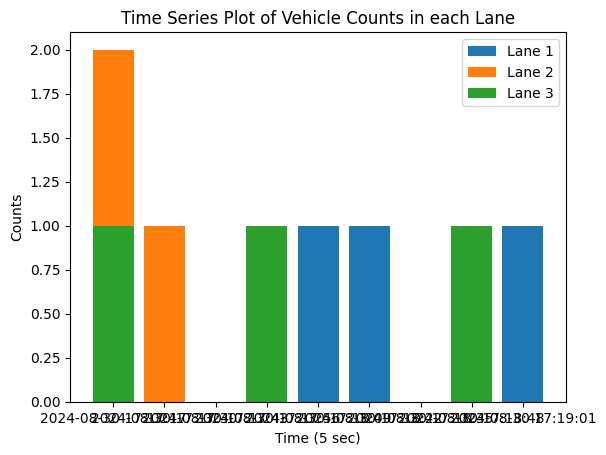

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(OUTPUT_CSV_PATH)

# Separate the time column (assuming it's the first column)
times = df.iloc[:, 0]

# Assuming the rest are numerical columns, extract them into separate DataFrames
data1 = df.iloc[:, 1]
data2 = df.iloc[:, 2]
data3 = df.iloc[:, 3]

# Plot the time series data
plt.bar(times, data1, label="Lane 1")
plt.bar(times, data2, label="Lane 2")
plt.bar(times, data3, label="Lane 3")

# Set labels for the axes and title for the plot 
plt.xlabel("Time (5 sec)")
plt.ylabel("Counts")
plt.title("Time Series Plot of Vehicle Counts in each Lane")

# Add a legend
plt.legend()

# Show the plot
plt.show()
